In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/Study/NLP/밑딥2/deep-learning-from-scratch-2

/content/drive/MyDrive/Study/NLP/밑딥2/deep-learning-from-scratch-2


In [ ]:
!ls

ch01  ch03  ch05  ch07	common	   dataset			LICENSE.md
ch02  ch04  ch06  ch08	cover.png  equations_and_figures_2.zip	README.md


In [ ]:
import numpy as np

# 5.1 확률과 언어 모델

## 5.1.1 word2vec을 확률 관점에서 바라보다

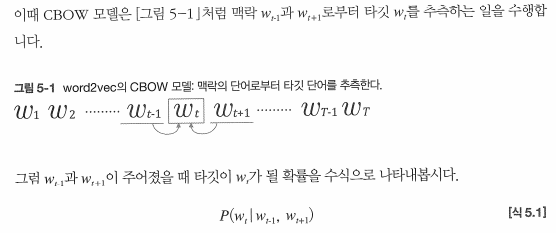

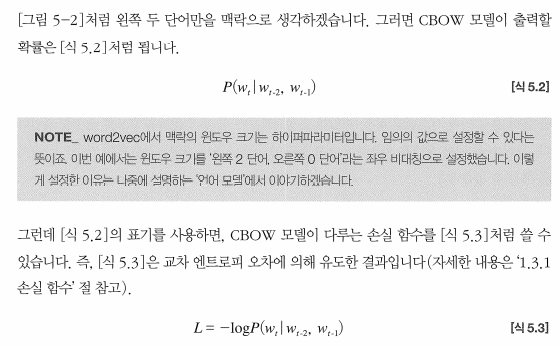

## 5.1.2 언어모델 ( 기계 번역, 음성 인식 )

* 언어 모델(Language Model)은 단어 나열에 확률을 부여한다. 특정한 단어의 시퀀스에 대해서 그 시퀀스가 일어날 가능성이 어느 정도인지( 얼마나 자연스러운 단어 순서인지 ) 를 확률로 평가하는 것. 

* ex) you say goodbye : 0.092
* ex) you say good die : 0.0000000032

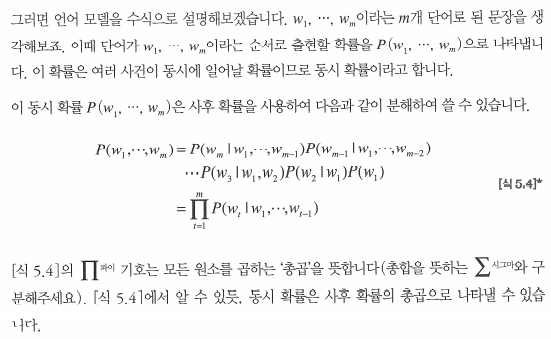

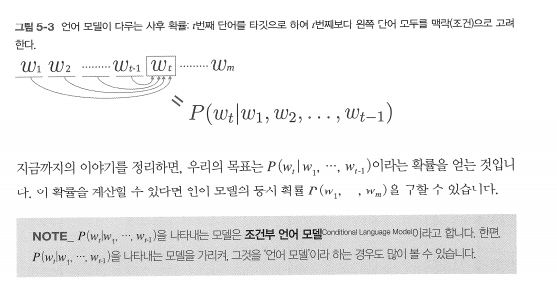

* 즉, 사후 확률을 구함으로써, 모두 곱하여 어떤 문장의 자연스러운 정도를 확률로 구할 수 있게된다.

## 5.1.3 CBOW 모델을 언어 모델로?

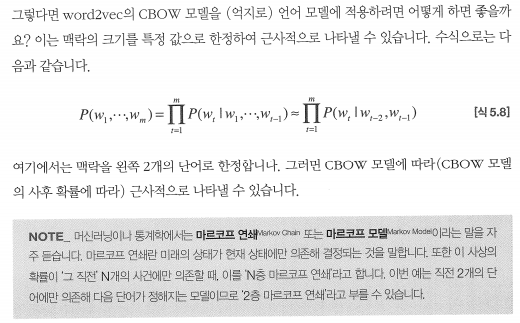

* CBOW 모델에서 맥락 안의 단어 순서가 무시된다.

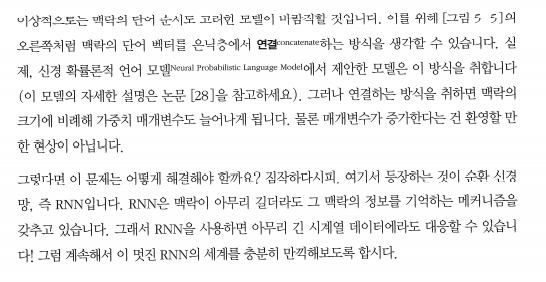

# 5.2 RNN이란 : 순환 신경망 

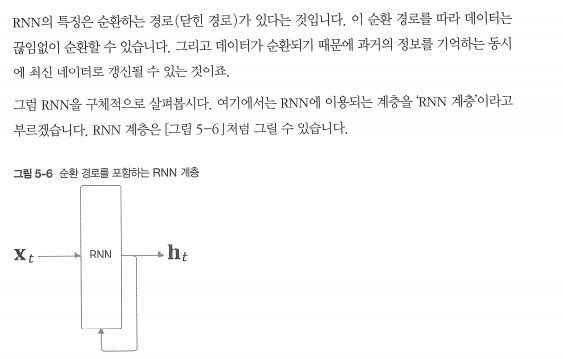

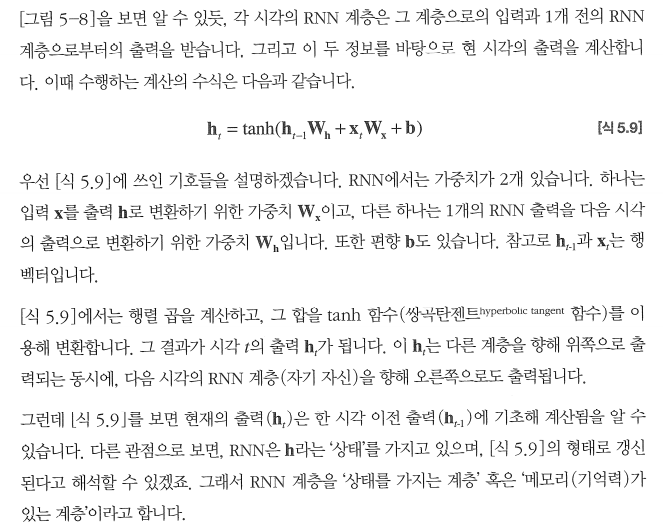

## 5.2.3 BPTT ( Backpropagation Through Time )

* BPTT를 이용해 기울기를 구하려면, 매 시각 RNN 계층의 중간 데이터를 메모리에 유지해두지않으면 안된다.
* 시계열 데이터가 길어짐에 따라 메모리 사용량도 증가하게된다.
* 컴퓨팅 자원 소비도 증가

## 5.2.4 Truncated BPTT

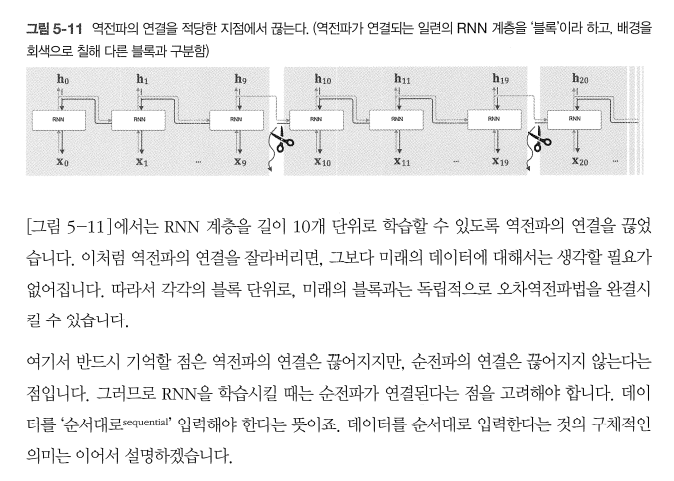

## 5.2.5 Truncated BPTT의 미니배치 학습

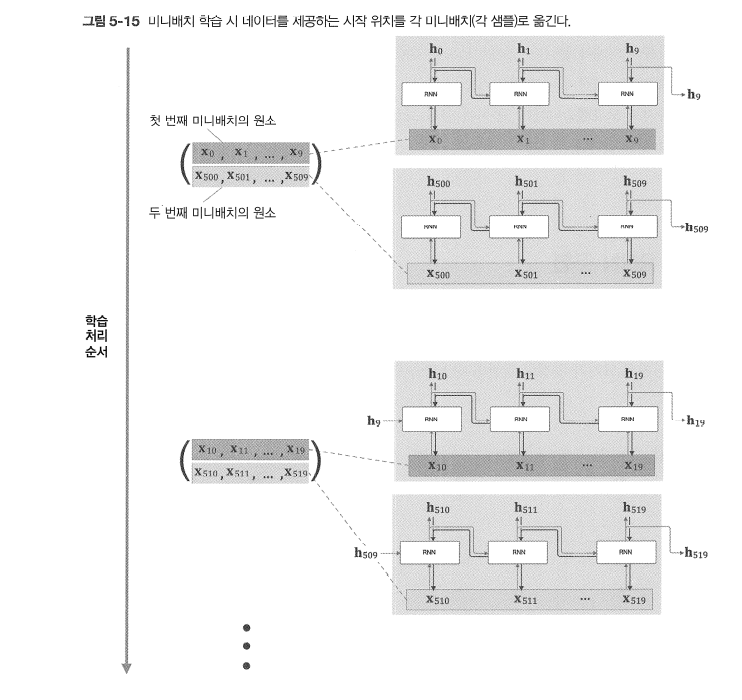



1.   데이터 순서대로 제공하기
2.   미니배치 별로 데이터를 제공하는 시작 위치를 옮기기



# 5.3 RNN 구현

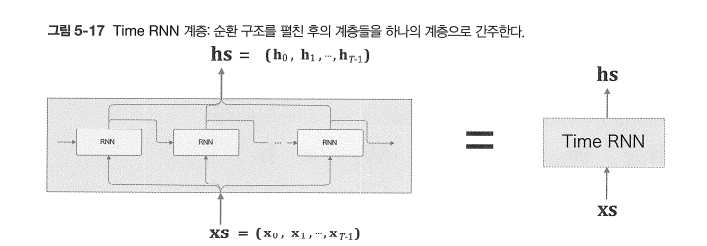

In [ ]:
class RNN:
  def __init__(self,Wx,Wh,b):
    self.params=[Wx,Wh,b]
    self.grads=[np.zeros_like(Wx),np.zeros_like(Wh),np.zeros_like(b)]
    self.cache=None

  def forward(self,x,h_prev):
    Wx,Wh,b=self.params
    t=np.matmul(h_prev,Wh)+np.matmul(x,Wx)+b
    h_next=np.tanh(t) # h_next = 다음 시각 계층으로의 입력

    self.cache=(x,h_prev,h_next)  # cache : 역전파 계산시 사용
    return h_next
  
  def backward(self,dh_next):
    Wx,Wh,b=self.params
    x,h_prev,h_next=self.cache

    dt=dh_next*(1-h_next**2)
    db=np.sum(dt,axis=0)
    dWh=np.matmul(h_prev.T,dt)
    dh_prev=np.matmul(dt,Wh.T)
    dWx=np.matmul(x.T,dt)
    dx=np.matmul(dt,Wx.T)

    self.grads[0][...]=dWx
    self.grads[1][...]=dWh
    self.grads[2][...]=db

    return dx,dh_prev

# 5.3.2 Time RNN 계층 구현 ( T개의 RNN 계층으로 구성 )

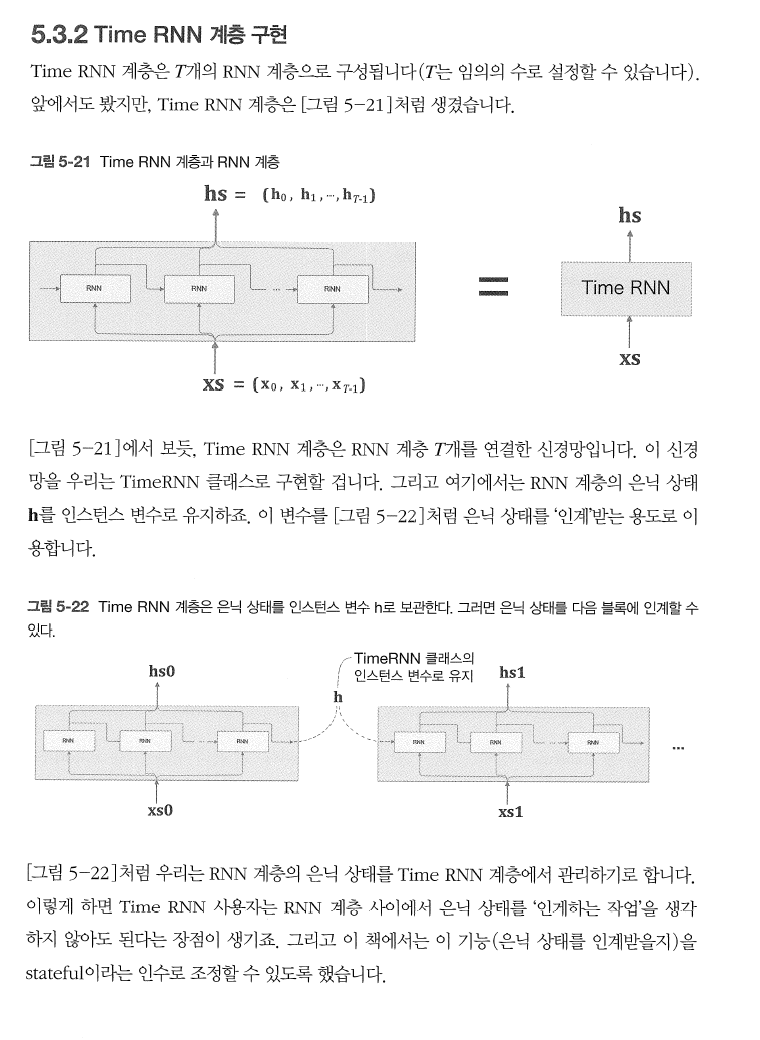

In [ ]:
class TimeRNN:
  def __init__(self,Wx,Wh,b,stateful=False): # stateful = RNN 계층 사이에서 은닉상태를 인계하는 작업을 조정. ( 이전의 은닉상태를 유지할지 말지 지정 )
    self.params[Wx,Wh,b]
    self.grads=[np.zeros_like(Wx),np.zeros_like(Wh),np.zeros_like(b)]
    self.layers=None # 다수의 RNN 계층을 리스트로 저장하는 용도

    self.h,self.dh=None,None # dh : backward() 메서드를 호출 했을 때 하나 앞 블록의 은닉상태의 기울기를 저장. ## ??
    self.stateful=stateful

  def set_state(self,h): # 은닉 상태 설정.
    self.h=h # forward() 메서드를 호출했을 때의 마지막 RNN 계층의 은닉상태를 저장
  
  def reset_state(self):
    self.h=None # 은닉상태의 초기화

  def forward(self,xs): # xs : T개 분량의 시계열 데이터를 하나로 모은 것.
    Wx,Wh,b=self.params
    N,T,D=xs.shape # (N,T,D) : 미니배치크기 N, 입력벡터의 차원 D
    D,H=Wx.shape

    self.layers=[]
    hs=np.empty((N,T,H),dtype='f') # 출력값을 담을 그릇

    if not self.stateful or self.h is None: # 첫 호출시 영행렬로 초기화
      self.h=np.zeros((N,H),dtype='f')

    for t in range(T):
      layer=RNN(*self.params) # self params에 들어있는 Wx,Wh,b를 추출하여 RNN 클래스의 __init__()메서드에 전달.
      self.h=layer.forward(xs[:,t,:],self.h)  # 시간 t의 은닉상태 h를 계산.
      hs[:,t,:]=self.h # hs의 시간 t에 해당 h값 저장.
      self.layers.append(layer)

    return hs

  def backward(self,dhs): 
    Wx,Wh,b=self.params
    N,T,H=dhs.shape
    D,H=Wx.shape

    dxs=np.empty((N,T,D),dtype='f')
    dh=0
    grads=[0,0,0]
    for t in reversed(range(T)):
      layer=self.layers[t] # 순전파와 반대 순서로 RNN 계층의 backward() 메서드를 호출.

      dx,dh=layer.backward(dhs[:,t,:]+dh) # 합산된 기울기 (dh(t) + dh(next)) : 분기하는 데이터이기 때문에 더해줌.

      dxs[:,t,:]=dx # 각 시각의 기울기 dx를 구해 dxs의 해당 인덱스(시각 t)에 저장. 

      for i,grad in enumerate(layer.grads):
        grads[i]+=grad
    for i,grad in enumerate(grads):
      self.grads[i][...]=grad

    self.dh=dh

    return dxs

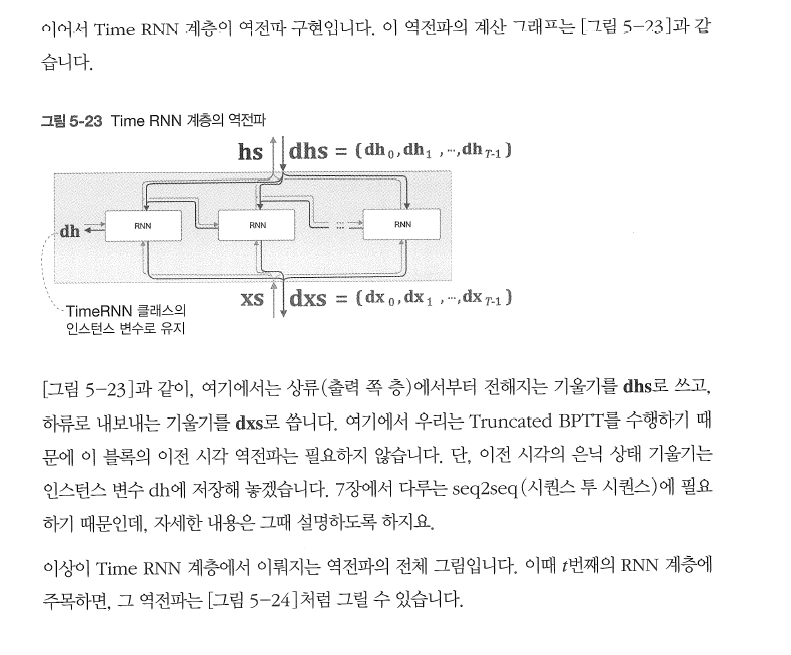

# 5.4 시계열 데이터 처리 계층 구현

## 5.4.1 RNNLM(RNN Language Model)의 전체 그림

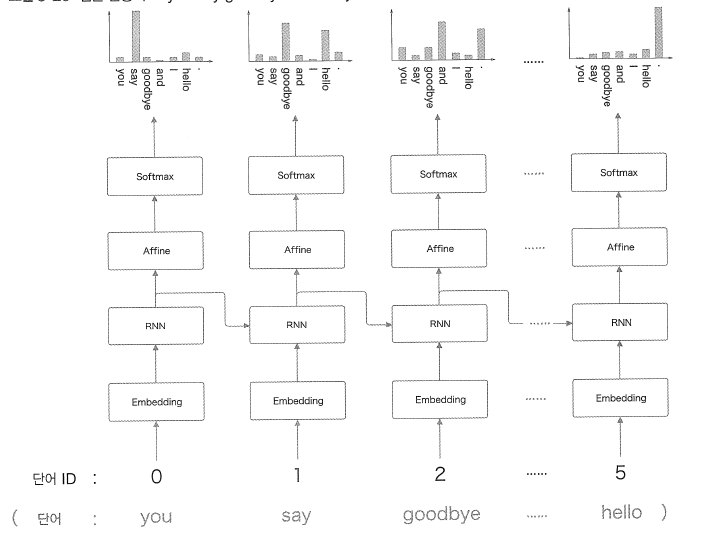

* 입력 : 단어 ID의 배열 ( 첫 번째 시각, : ID = 0 , "you" ) 

* RNN 계층이 "you say"(과거의 )맥락을 기억하고 있다는 사실이 중요하다.
* 즉, 과거의 정보를 응집된 은닉 상태 벡터로 저장해두고 있다.
* RNNLM은 지금까지 입력된 단어를 '기억'하고, 그것을 바탕으로 다음에 출현할 단어를 예측한다. 이것을 가능하게 하는 비결이 바로 RNN 계층의 존재이다.
* RNN 계층이 과거에서 현재로 데이터를 계속 흘려보내줌으로써 과거의 정보를 인코딩해 저장할 수 있다.

## 5.4.2 Time 계층 구현

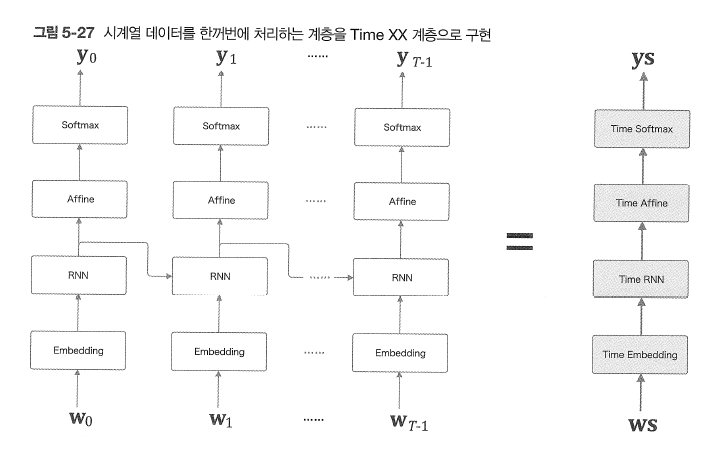

* Embedding, Affine -> Time Embedding, Time Affine : 각 시각의 데이터를 개별적으로 처리하는 식으로 구현
* Time Softmax with Loss : T개의 softmax 계층의 각각의 손실들을 산출하고, 합산해 평균한 값이 최종 손실이 되도록 함. (N개의 미니배치에 해당하는 손실의 평균을 구한다.)

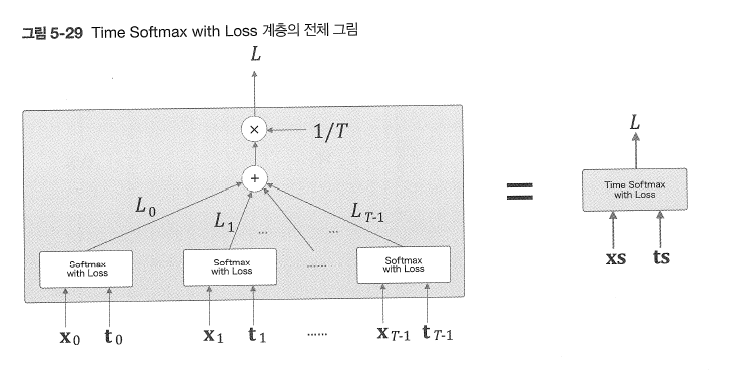

# 5.5 RNNLM 학습과 평가

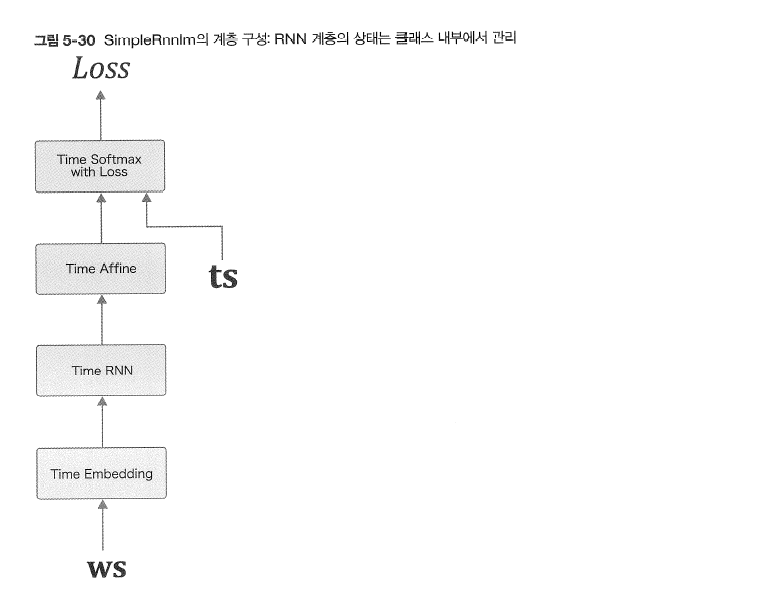

In [ ]:
import numpy as np 
from common.time_layers import *

class SimpleRnnlm:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        # 가중치 초기화 , Xavier(사비에르) 초깃값 이용. ## ?? 학습 진행과 정확도가 크게 달라진다고 함.
        embed_W = (rn(V, D) / 100).astype('f')
        rnn_Wx = (rn(D, H) / np.sqrt(D)).astype('f')
        rnn_Wh = (rn(H, H) / np.sqrt(H)).astype('f')
        rnn_b = np.zeros(H).astype('f')
        affine_W = (rn(H, V) / np.sqrt(H)).astype('f')
        affine_b = np.zeros(V).astype('f')

        # 계층 생성
        self.layers = [
            TimeEmbedding(embed_W),
            TimeRNN(rnn_Wx, rnn_Wh, rnn_b, stateful=True), # Truncated BPTT로 학습한다는 가정. ( 이전 시각의 은닉상태 계승)
            TimeAffine(affine_W, affine_b)
        ]
        self.loss_layer = TimeSoftmaxWithLoss()
        self.rnn_layer = self.layers[1]

        # 모든 가중치와 기울기를 리스트에 모은다.
        self.params, self.grads = [], []
        for layer in self.layers:
            self.params += layer.params
            self.grads += layer.grads

    def forward(self, xs, ts):
        for layer in self.layers: # layer 순서대로 호출.
            xs = layer.forward(xs)
        loss = self.loss_layer.forward(xs, ts) # 총 손실 계산 Time Softmax with Loss
        return loss 

    def backward(self, dout=1):
        dout = self.loss_layer.backward(dout)
        for layer in reversed(self.layers): # 거꾸로 호출.
            dout = layer.backward(dout)
        return dout

    def reset_state(self):
        self.rnn_layer.reset_state()

## 5.5.2 언어 모델의 평가

* perplexity  : 확률의 역수값 사용.
** 좋은 모델 : 높은 확률로 예측, 낮은 perplexity
** 나쁜 모델 : 낮은 확률로 예측, 큰 perplexity
* 직관적인 의미 : 다음에 출현할 수 있는 단어의 후보 수

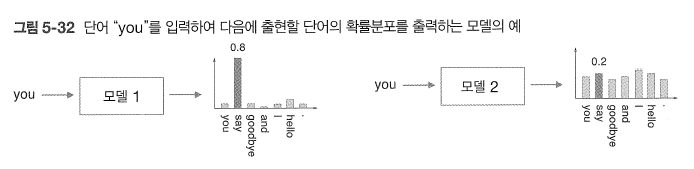

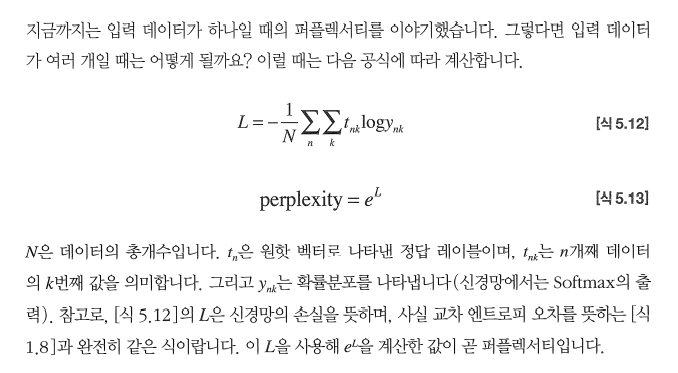

## 5.5.3 RLLNM의 학습 코드

말뭉치 크기: 1000, 어휘 수: 418
| 에폭 1 | 퍼플렉서티 392.37
| 에폭 2 | 퍼플렉서티 267.91
| 에폭 3 | 퍼플렉서티 224.41
| 에폭 4 | 퍼플렉서티 214.88
| 에폭 5 | 퍼플렉서티 205.95
| 에폭 6 | 퍼플렉서티 203.07
| 에폭 7 | 퍼플렉서티 198.42
| 에폭 8 | 퍼플렉서티 195.74
| 에폭 9 | 퍼플렉서티 190.82
| 에폭 10 | 퍼플렉서티 193.56
| 에폭 11 | 퍼플렉서티 188.31
| 에폭 12 | 퍼플렉서티 191.02
| 에폭 13 | 퍼플렉서티 190.28
| 에폭 14 | 퍼플렉서티 190.03
| 에폭 15 | 퍼플렉서티 188.65
| 에폭 16 | 퍼플렉서티 185.21
| 에폭 17 | 퍼플렉서티 182.74
| 에폭 18 | 퍼플렉서티 179.29
| 에폭 19 | 퍼플렉서티 180.85
| 에폭 20 | 퍼플렉서티 181.99
| 에폭 21 | 퍼플렉서티 179.51
| 에폭 22 | 퍼플렉서티 176.26
| 에폭 23 | 퍼플렉서티 173.02
| 에폭 24 | 퍼플렉서티 174.37
| 에폭 25 | 퍼플렉서티 171.09
| 에폭 26 | 퍼플렉서티 170.65
| 에폭 27 | 퍼플렉서티 164.99
| 에폭 28 | 퍼플렉서티 163.22
| 에폭 29 | 퍼플렉서티 161.28
| 에폭 30 | 퍼플렉서티 156.36
| 에폭 31 | 퍼플렉서티 155.53
| 에폭 32 | 퍼플렉서티 149.68
| 에폭 33 | 퍼플렉서티 149.74
| 에폭 34 | 퍼플렉서티 144.52
| 에폭 35 | 퍼플렉서티 143.21
| 에폭 36 | 퍼플렉서티 135.69
| 에폭 37 | 퍼플렉서티 131.44
| 에폭 38 | 퍼플렉서티 127.97
| 에폭 39 | 퍼플렉서티 123.33
| 에폭 40 | 퍼플렉서티 118.54
| 에폭 41 | 퍼플렉서티 116.53
| 에폭 42 | 퍼플렉서티 110.33
| 에폭 43 | 퍼플렉서티 104

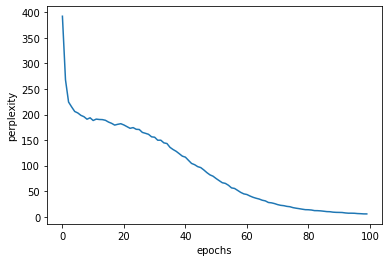

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from common.optimizer import SGD
from dataset import ptb
from ch05.simple_rnnlm import SimpleRnnlm


# 하이퍼파라미터 설정
batch_size = 10
wordvec_size = 100
hidden_size = 100 # RNN의 은닉 상태 벡터의 원소 수
time_size = 5     # Truncated BPTT가 한 번에 펼치는 시간 크기
lr = 0.1
max_epoch = 100

# 학습 데이터 읽기(전체 중 1000개만)
corpus, word_to_id, id_to_word = ptb.load_data('train')
corpus_size = 1000
corpus = corpus[:corpus_size]
vocab_size = int(max(corpus) + 1)

xs = corpus[:-1]  # 입력
ts = corpus[1:]   # 출력(정답 레이블)
data_size = len(xs)
print('말뭉치 크기: %d, 어휘 수: %d' % (corpus_size, vocab_size))

# 학습 시 사용하는 변수
max_iters = data_size // (batch_size * time_size)
time_idx = 0
total_loss = 0
loss_count = 0
ppl_list = []

# 모델 생성
model = SimpleRnnlm(vocab_size, wordvec_size, hidden_size)
optimizer = SGD(lr)

# 미니배치의 각 샘플의 읽기 시작 위치를 계산
jump = (corpus_size - 1) // batch_size
offsets = [i * jump for i in range(batch_size)]

for epoch in range(max_epoch):
    for iter in range(max_iters):
        # 미니배치 취득
        batch_x = np.empty((batch_size, time_size), dtype='i')
        batch_t = np.empty((batch_size, time_size), dtype='i')
        for t in range(time_size):
            for i, offset in enumerate(offsets):
                batch_x[i, t] = xs[(offset + time_idx) % data_size]
                batch_t[i, t] = ts[(offset + time_idx) % data_size]
            time_idx += 1

        # 기울기를 구하여 매개변수 갱신
        loss = model.forward(batch_x, batch_t)
        model.backward()
        optimizer.update(model.params, model.grads)
        total_loss += loss
        loss_count += 1

    # 에폭마다 퍼플렉서티 평가
    ppl = np.exp(total_loss / loss_count)
    print('| 에폭 %d | 퍼플렉서티 %.2f'
          % (epoch+1, ppl))
    ppl_list.append(float(ppl))
    total_loss, loss_count = 0, 0

# 그래프 그리기
x = np.arange(len(ppl_list))
plt.plot(x, ppl_list, label='train')
plt.xlabel('epochs')
plt.ylabel('perplexity')
plt.show()

## 5.5.4 RNNLM의 Trainer 클래스


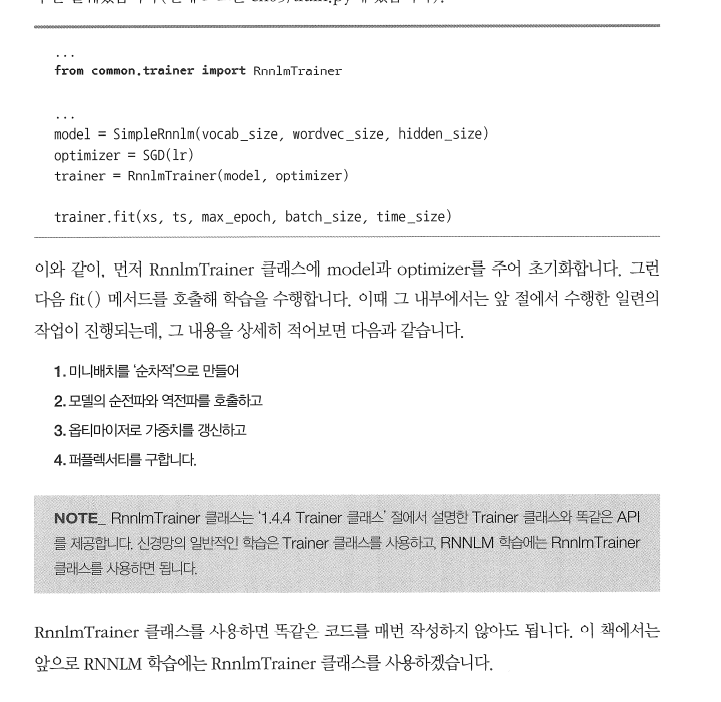

# 5.6 정리

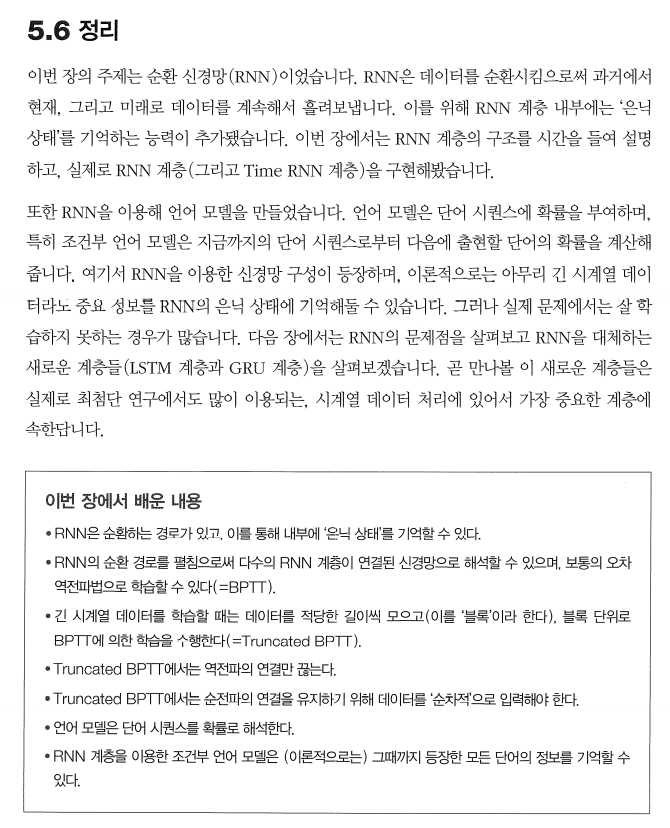